In [1]:
%load_ext autoreload
%autoreload 2
from tqdm import tqdm
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import operator,json, re, itertools 
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
# from wordcloud import WordCloud 
pd.options.display.max_colwidth = 300
import seaborn as sns
import config
data_root= config.DATA_ROOT
tqdm.pandas()
# import collect_tweets

In [2]:
df=pd.read_pickle(data_root+'tweets-priv.pkl')
print("# of privacy related tweets: {}\n# of unique users who tweeted:{}".format(len(df), len(df.author_id.unique())))

# of privacy related tweets: 216667
# of unique users who tweeted:90579


In [59]:
# df[['text', 'conversation_id']]
# reply= df[df.apply(lambda t: t.conversation_id!=int(t.name), axis=1)]
# print(reply.shape)
# reply.head()[['text', 'conversation_id']]
df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con'],
      dtype='object')

In [78]:
user_df = pd.read_pickle(data_root+'users-en-unique.pkl')
print('total # of users', len(user_df))

total # of users 1698096


In [79]:
deleted_users = set(df.author_id.unique()).difference(user_df.index)
print('# of users who tweeted sec-priv tweets but deleted their accounts:', len(deleted_users))
current_users = set(df.author_id).intersection(user_df.index)
print('# of users who tweeted sec-priv tweets and have their accounts:', len(current_users))
user_df=user_df.loc[list(current_users)]

# of users who tweeted sec-priv tweets but deleted their accounts: 0
# of users who tweeted sec-priv tweets and have their accounts: 63807


In [80]:
'''remove tweets from deleted users as per TOS'''
df=df[df.apply(lambda row: row.author_id in current_users, axis=1)]
df.shape

(163658, 25)

In [81]:
df["created_at"] = pd.to_datetime(df["created_at"])

In [82]:
df['search_grp'] = df.apply(lambda tweet: 
                            'mention' if tweet.search_term.startswith('@') \
                            else ('hashtag' if tweet.search_term.startswith('#') else 'other'), axis=1)

In [83]:
'''Parse the entities in a tweet object'''

def singleQuoteToDoubleQuote(singleQuoted):
        '''
        convert a single quoted string to a double quoted one
        Args:
            singleQuoted(string): a single quoted string e.g. {'cities': [{'name': "Upper Hell's Gate"}]}
        Returns:
            string: the double quoted version of the string e.g. 
        see
           - https://stackoverflow.com/questions/55600788/python-replace-single-quotes-with-double-quotes-but-leave-ones-within-double-q 
        '''
        cList=list(singleQuoted)
        inDouble=False;
        inSingle=False;
        for i,c in enumerate(cList):
            #print ("%d:%s %r %r" %(i,c,inSingle,inDouble))
            if c=="'":
                if not inDouble:
                    inSingle=not inSingle
                    cList[i]='"'
            elif c=='"':
                inDouble=not inDouble
        doubleQuoted="".join(cList)    
        return doubleQuoted
    
def parse_entity(row):
    if isinstance(row.entities, str):
        try:
            return json.loads(singleQuoteToDoubleQuote(row.entities).replace(u'\\xa0', u' '))
        except Exception as e:
            print(row.name, e)
            return {}
    else: 
        return {}
df['entities_parsed']= df.progress_apply(lambda row: parse_entity(row), axis=1)
# parse_entity(df.loc['1470058531546148880'])

 83%|███████████████████████████████████████████████████████████████████████████████████████████▍                  | 136050/163658 [00:06<00:01, 24834.76it/s]

1470755533770694661 Expecting ',' delimiter: line 1 column 763 (char 762)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163658/163658 [00:07<00:00, 22395.90it/s]


In [84]:
keys = df.apply(lambda row: list(row.entities_parsed.keys()), axis=1)
keys=list(itertools.chain.from_iterable(keys.values))
len(keys),set(keys)

(104257, {'annotations', 'cashtags', 'hashtags', 'mentions', 'urls'})

In [85]:
df['urls'] = df.apply(lambda row: [urlparse(url['expanded_url']).netloc for url in row.entities_parsed['urls']] \
                      if 'urls' in row.entities_parsed else [], axis=1)
df['hashtags'] = df.apply(lambda row: [hashtag['tag'] for hashtag in row.entities_parsed['hashtags']] \
                      if 'hashtags' in row.entities_parsed else [], axis=1)
df['anno_type'] = df.apply(lambda row: [a['type'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['anno_text'] = df.apply(lambda row: [a['normalized_text'] for a in row.entities_parsed['annotations']] \
                      if 'annotations' in row.entities_parsed else [], axis=1)
df['mentions'] = df.apply(lambda row: [m['username'] for m in row.entities_parsed['mentions']] \
                      if 'mentions' in row.entities_parsed else [], axis=1)

In [86]:
def entity_stat(df, common=5):
    print('Number of tweets with url(s):', len(df[df.apply(lambda row: len(row.urls)>0, axis=1)]))
    print('Number of tweets with hashtag(s):', len(df[df.apply(lambda row: len(row.hashtags)>0, axis=1)]))
    print('Number of tweets with annotations(s):', len(df[df.apply(lambda row: len(row.anno_type)>0, axis=1)]))
    print('Number of tweets with mention(s):', len(df[df.apply(lambda row: len(row.mentions)>0, axis=1)]))
    print()
    mentions = list(itertools.chain.from_iterable(df.mentions.values))
    tags=list(itertools.chain.from_iterable(df.hashtags.values))
    urls=list(itertools.chain.from_iterable(df.urls.values))
    anno_type=list(itertools.chain.from_iterable(df.anno_type.values))
    anno_text=list(itertools.chain.from_iterable(df.anno_text.values))
    print('urls: {}, unique:{}, most_common:{}'.format(len(urls), len(set(urls)), Counter(urls).most_common(common)))
    print('mentions: {}, unique:{}, most_common:{}'.format(len(mentions), len(set(mentions)), Counter(mentions).most_common(common)))
    print('tags: {}, unique:{}, most_common:{}'.format(len(tags), len(set(tags)), Counter(tags).most_common(common)))
    print('anno_type: {}, unique:{}, most_common:{}'.format(len(anno_type), len(set(anno_type)), Counter(anno_type).most_common(common)))
    print('anno_text: {}, unique:{}, most_common:{}'.format(len(anno_text), len(set(anno_text)), Counter(anno_text).most_common(common)))

In [162]:
entity_stat(df , common=10)

Number of tweets with url(s): 40541
Number of tweets with hashtag(s): 41776
Number of tweets with annotations(s): 6666
Number of tweets with mention(s): 15245

urls: 50868, unique:3020, most_common:[('twitter.com', 11127), ('bit.ly', 8833), ('ow.ly', 6447), ('buff.ly', 2516), ('hubs.ly', 1440), ('gag.gl', 897), ('stwb.co', 858), ('okt.to', 799), ('goo.gl', 772), ('lnkd.in', 593)]
mentions: 22541, unique:7879, most_common:[('ZDNet', 226), ('EdTech_K12', 220), ('CIOonline', 206), ('InfosecurityMag', 205), ('ITProPortal', 175), ('NTTComSec_UK', 168), ('helpnetsecurity', 161), ('SearchSecurity', 160), ('CSOonline', 150), ('MdMisi', 131)]
tags: 144506, unique:10328, most_common:[('BYOD', 33591), ('security', 12834), ('cybersecurity', 5280), ('byod', 4103), ('infosec', 4082), ('mobile', 3653), ('privacy', 1553), ('mobilesecurity', 1463), ('IoT', 1444), ('Cybersecurity', 1401)]
anno_type: 8125, unique:5, most_common:[('Organization', 3343), ('Person', 1790), ('Product', 1606), ('Place', 1183)

In [50]:
# t=df[df.apply(lambda row: 'twitter.com' in row.urls[0] if row.urls else False, axis=1)]
# pd.options.display.max_colwidth=390
# t[['text']]
df.columns

Index(['author_id', 'text', 'created_at', 'geo', 'retweets', 'replies',
       'likes', 'quote_count', 'lang', 'conversation_id',
       'context_annotations', 'entities', 'attachments', 'possibly_sensitive',
       'withheld', 'reply_settings', 'source', 'search_term', 'senti', 'topic',
       'text_clean_topic', 'text_clean_senti', 'topic_cos', 'topic_con',
       'search_grp', 'entities_parsed', 'urls', 'hashtags', 'anno_type',
       'anno_text', 'mentions'],
      dtype='object')

In [87]:
def get_tweet_type(tweet):
    for url in tweet.urls:
        if 'twitter.com' in url:
            return 'quote'
    if int(tweet.name)!=tweet.conversation_id:
        return 'reply'
    return 'novel'

df['tweet_type'] = df.apply(lambda tweet: get_tweet_type(tweet), axis=1)

In [88]:
df.groupby('tweet_type').text.count()

tweet_type
novel    134332
quote     11023
reply     18303
Name: text, dtype: int64

df.to_pickle(data_root+'tweets-priv-processed.pkl')## Who tweeted? Find user groups

In [74]:
uids = set(user_df.index)
df['author_group'] = df.progress_apply(lambda row: user_df.loc[row.author_id].user_group if row.author_id in uids else 'Unknown', axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163658/163658 [00:40<00:00, 4005.34it/s]


In [237]:
df[df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().sort_values(ascending=False).to_frame().head(10)

,,text
author_group,tweet_type,
business_brand,novel,37212
personal_brand,novel,17845
academic_techi,novel,15711
news,novel,11315
academic,novel,6078
business_brand,quote,5695
techie,novel,3289
academic_techi,reply,2913
academic,reply,2000


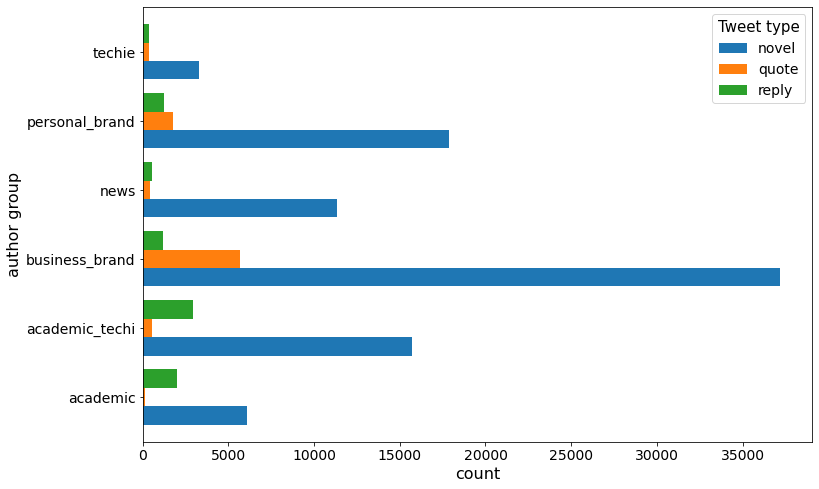

In [234]:
df[df.author_group!='unknown'].groupby(['author_group', 'tweet_type']).text.count().unstack().plot(kind='barh', width=.8, figsize=(12,8))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('count', fontsize=16)
plt.ylabel('author group', fontsize=16)
plt.legend(title="Tweet type", title_fontsize=15, fontsize=14, fancybox=True)
plt.show()

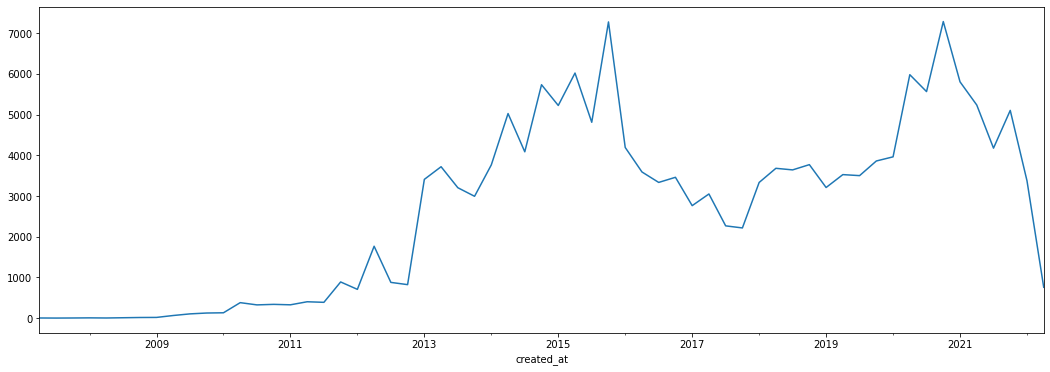

In [55]:
plt.figure(figsize=(18,6))
df.reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot()
plt.title('')
plt.show()

In [89]:
df.to_pickle(data_root+'tweets-priv-processed.pkl')

## Tweet sentiment

In [56]:
# def remove_comp(senti):
#     if 'compound' in senti:
#         senti.pop('compound')
#     return senti
# df['senti2'] = df.apply(lambda tweet: remove_comp(tweet.senti), axis=1)
# df['senti2'] = df.apply(lambda tweet: max(tweet.senti2.items(), key=operator.itemgetter(1))[0], axis=1)

In [57]:
df.groupby('senti').text.count()

senti
negative      7309
neutral     148082
positive      8267
Name: text, dtype: int64

In [58]:
df.groupby(['tweet_type','senti']).text.count()#.sort_values(ascending=False)

tweet_type  senti   
novel       negative      5651
            neutral     121958
            positive      6736
quote       negative       193
            neutral      10318
            positive       499
reply       negative      1465
            neutral      15806
            positive      1032
Name: text, dtype: int64

In [59]:
df[df.senti=='negative'].groupby(['author_group']).text.count().sort_values(ascending=False)

author_group
unknown           3545
business_brand    1327
academic_techi     823
personal_brand     579
news               451
academic           413
techie             171
Name: text, dtype: int64

In [60]:
neg_df = df[df.senti=='negative']

In [29]:
sample1 = pd.read_excel('priv-tweets-neg-sample1.xls')
sample1.tweetid = sample1.tweetid.astype(str)
sample1.set_index('tweetid', inplace=True)

In [30]:
df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]

/var/folders/q5/tcs66y_j6z1bcz8ffp7_1m4r0000gq/T/ipykernel_55137/1178873254.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df.loc[(set(sample1.index).intersection(set(df[df.senti=='negative'].index)))].sample(10)[['text']]


,text
tweetid,
388933694498406400,No Recourse for Girls Harassed by Transgender Bully http://t.co/XI0FlCUhAb CO girls' privacy jeopardized by one gender confused moron=wrong
25920117445,I'm truly horrified by the circumstances of this young Rutgers student's invasion of privacy and subsequent suicide. http://bit.ly/bKaQBj
27787390340833280,"Teacher Punished for Reporting Violent 7-Year-Old: http://abcn.ws/eP17QU. Did she violate the student's privacy, or do the right thing?"
1455170658371977226,@CheetahJim1 @ProFootballTalk Not saying it's right to violate one's privacy but where were y'all when Linda Tripp was violating Monica Lewinski? People get violated by the system every day. Your typical college rape of a student by a professor involves far more violation than poor millionaire...
1337484131928862727,This is why I get mad when edtech or tech platforms get applauded \n\nNo one EVER asks what the fuck is going on in schools with privacy \n\nAnd let me tell you it is a mess because half the staff don’t know and the other half are wannabe prison guards https://t.co/GRkU0cBfHH
1122934665122320384,A student cleared of rape when his accuser’s text messages proved his innocence said this morning that rape suspects deserve the same right to privacy as victims https://t.co/rt13k0DI34
1025695617048301568,"@BostonDotCom WTF? This is disgusting. She's a student that work hard to get into college and she gets target b/c she a person of color and they're worried about the ""privacy laws"" after this young woman got humiliated for doing nothing wrong. Get the hell out here with that BS."
180695154313805824,"Dharun Ravi, ex Rutgers Univ student was found guilty on charges of invasion of privacy, but not guilty charges of bias intimidation"
9293828456,"Absolutely horrifying: ""School used student laptop webcams to spy on them at school and at home"" http://bit.ly/apfgRf #privacy"


In [31]:
df[df.senti=='negative'].sample(10)[['text']]

,text
tweetid,
101695842209107968,Court sides with college accused of snooping on student’s email account http://e74.us/8w #privacy RT @internetcases &lt; Unencrypted = insecure
344785106378043393,BYOD &amp; the implications for the IT team http://t.co/SM6MAuiqkB #tech #news #BYOD #mobile #IT #security
941678592970379265,See how @usedgov now investigating @MoskowitzEva &amp; @SuccessCharters for violations of student privacy #FERPA @MarkTreyger718 @Parents4Privacy @FatimaFarax @NYCKidsPAC @jbelluck @CoreyinNYC @Dromm25 @ChalkbeatNY @NYDNBenChapman @katetaylornyt https://t.co/d0PYXySLy9
289560706506969088,School privacy policies are dangerous. Coworker was not allowed to learn name of student who fractured son's skull due to privacy policy.
1336323095565459461,"@susanoha Some edtech is great and others are an abomination, digiLEARN is selling the abomination edtech that is expensive, sunders privacy and harms children. https://t.co/WYSvU3mEM8"
1325974559506522112,"@PublixHelps The chairs to the right in the grocery store was where 2 people in the pharmacy, first a student and then the pharmacist, tried to give me the flu vaccine. I refused because this is unacceptable. No privacy. Pathetic pt care! https://t.co/t4O0wn4MPf"
854077533104427008,MT @TeriGRight: #CommonCore intrusive data mining threatens student privacy! #KeepYourPromise #StopCommonCore https://t.co/6xyB74ntJa #PJNET
1101672288985014272,The latest Hecht Hyperborean! https://t.co/YJKNCaAxez Thanks to @catacalypto @twmillar @nevesytrof #privacy #edtech
310032618819297281,"Allure of ""21st-century technology"" masks privacy-undermining agenda of those allergic to..parental autonomy. http://t.co/gMGlL2xZk4"


### Topics

In [61]:
priv_topics = [line.split(':')[1] for line in open('priv-tweet-topics.txt')]
for pt in range(len(priv_topics)):
    print(pt, priv_topics[pt].strip())

0 gauge pseudonym tyranny culprit sarcasm ludicrous nefarious pedophile disingenuous fwiw
1 edtech cybersecurity dfir skillsgap nlproc ingramtechsol systemsthinke stcenturyskill thecybersecurityplace cybint
2 datum protect sotu schoolprivacyzone paigekowalski datadrivesresult rachelbarrer takectrl replukemesser benjaminbherold
3 username share talk story daily event awesome tune david advisor
4 school lifeleader schoolchildren safeschool studentvoice chooseprivacy schooldistrict coetail powerschool indyschool
5 security byod mobile device enterprisesecurity byodsecurity fiercemobileit securityrisk dellsecurity symantec
6 privacy student news washington priva myname privac stud studentright priv
7 facebook internship flaw austrian lose harvard expose highlight messenger cancel
8 conclude cpdp myriad minefield txcto asugsv sotn bettertogether nuisance rundown
9 neighborhood georgetown auburn nazi chattanooga tulsa knife sixth uconn franklin


In [33]:
interesting_topics=[0, 1,2 ,3,4,6]
# 0: talks about tyranny of EdTech
# 1: ingramtechsol, thecybersecurityplace, cybint-->general cybersecurity, 
# 2: names of politicians, journalists who talk about (privacy?) policy
# 3: news, articles, announcements, some about how to prevent security/privacy issues 
# 4: similar to 0
# 5: about BOYD, ignore

In [58]:
df.groupby('topic').text.count().sort_values(ascending=False)#.head(10)

topic
 6    104699
 5     37108
 1     12735
 3      6447
 2      1205
 4       702
-1       699
 7        48
 0        12
 9         3
Name: text, dtype: int64

### Sample negative tweets for each topic for manual annotation 

In [63]:
# neg_df = df[df.senti=='negative']
# neg_df['link']=neg_df.apply(lambda r: 'http://twitter.com/u/status/{}'.format(r.name), axis=1)
# neg_df.groupby('topic').text.count().sort_values(ascending=False).head(10)

In [64]:
# neg_df[neg_df.topic<5][['text', 'link']].to_excel('neg-tweet-[0-4].xls')

In [62]:
# tdf= df[df.apply(lambda row: row.topic==5 and 'edtech' in row.text.lower(), axis=1)]
# print(len(tdf))
# tdf[['text']].to_excel('neg-tweet-5.xls')
# tdf.sample(np.min([10,len(tdf)]))[['text', 'topic','topic_cos','created_at']]

#### Who tweeted under Topic 5?

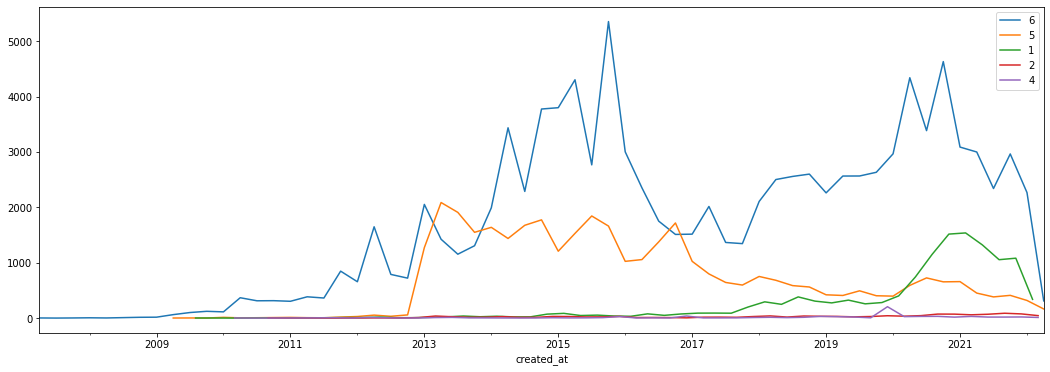

In [45]:
plt.figure(figsize=(18,6))
for topic in [6,5,1,2, 4]:
    df[df.topic==topic].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label=str(topic))
# df[df.topic==15].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 15')
# df[df.topic==10].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 10')
# df[df.topic==1].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 1')
# df[df.topic==8].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 8')
# df[df.topic==19].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label='topic 19')
plt.legend()
plt.show()

### remove duplicate tweets

In [100]:
topic_6 = pd.read_excel('neg-tweet-6.xlsx')#pd.concat([pd.read_excel('neg-tweet-6.xlsx').iloc[:1753], pd.read_excel('neg-tweet-6-no-dup.xlsx')[1753:]])
# print(topic_6.shape)
# dups = [line.strip() for line in open('duplicates.txt')][0].split(',')
# dups=list(filter(None, dups))
# dup_tweets = []
# for dup in dups:
#     dup_tweets += list(topic_6[topic_6.apply(lambda row: dup.strip().lower() in row.text.lower() and \
#                                              (isinstance(row.Code1, float) or len(row.Code1)==0), axis=1)].index)
# len(dup_tweets)
topic_6[topic_6.apply(lambda row: ' rfid ' in row.text.lower(), axis=1)] 

,tweetid,text,link,Code1
227,274139809994403840,Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/W9nATCTl #rfid #privacy,https://twitter.com/u/status/274139809994403840,NaN
279,272372537739063296,Student Suspended for Refusing to Wear a School-Issued RFID Tracker #privacy #tecnology http://t.co/CV4ia7js,https://twitter.com/u/status/272372537739063296,NaN
369,271327255509233664,Big Brother wants $$$ RT @YourAnonNews: Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/fF1Mzp5I #privacy,https://twitter.com/u/status/271327255509233664,NaN
746,272101976010018816,Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/Gb9gfjXw #privacy,https://twitter.com/u/status/272101976010018816,NaN
770,271320611240955905,Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/CAMpLT8P #privacy,https://twitter.com/u/status/271320611240955905,NaN
793,292790234180091904,Student Kicked Out Of School For Refusing To Wear RFID Tracking Badge Following Failed Appeal | CNS News http://t.co/8J2N2VsA #privacy,https://twitter.com/u/status/292790234180091904,NaN
853,271323345839071233,#privacy #p2 Student Suspended for Refusing to Wear a School-Issued RFID Tracker | Threat Level | http://t.co/h1M1G9Jy http://t.co/Jtxbt6ds,https://twitter.com/u/status/271323345839071233,NaN
1123,271348606919913472,Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/PWsaJ2L0 #privacy @AbbyCop,https://twitter.com/u/status/271348606919913472,NaN
1710,271835817406783490,I like RFID but defend privacy RT @Techmeme: Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/85nXczjz,https://twitter.com/u/status/271835817406783490,NaN
1999,271321302554533890,This is insane! RT @YourAnonNews: Student Suspended for Refusing to Wear a School-Issued RFID Tracker http://t.co/6gfjqF7Z #privacy,https://twitter.com/u/status/271321302554533890,NaN


In [66]:
# no_dup=topic_6.drop(index=dup_tweets)
# print(no_dup.shape)
# no_dup[['text','Code1', 'link']].to_excel('neg-tweet-6-final.xlsx')

### Analyze labelled tweets

In [3]:
def get_tfidf_top_features(documents,n_top=10):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(documents)
    importance = np.argsort(np.asarray(tfidf.sum(axis=0)).ravel())[::-1]
    tfidf_feature_names = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_feature_names[importance[:n_top]]


In [4]:
# labled_df = pd.concat([pd.read_csv('neg-tweet-6-final.csv',  sep=',', encoding = "utf-8"),
#                       pd.read_csv('neg-tweet-(0-4).csv',  sep=',', encoding = "utf-8")])
# labled_df['tweetid'] = labled_df.apply(lambda row: row.link.split('/')[-1], axis=1)
# labled_df = labled_df[labled_df.apply(lambda row: isinstance(row.Code, str) and len(row.Code.strip())>2, axis=1)]

# df= pd.read_csv('neg-tweet-5.csv',  sep=',', encoding = "utf-8")
# df['tweetid']=df.tweetid.astype(str)
# labled_df=pd.concat([labled_df, df])

# labled_df.set_index('tweetid', inplace=True)
# print(labled_df.shape)
# labled_df=labled_df[['text', 'Code']]
# labled_df.to_csv('all-sec-priv-labeled-tweets.csv', encoding='utf-8')
# labled_df.tweetid=labled_df.tweetid.astype(str)
# labled_df.set_index('tweetid', inplace=True)

# ldf=df.loc[labled_df.index]
# ldf['code'] = labled_df.Code
# ldf.shape
# ldf.to_pickle('all-sec-priv-labeled-tweets.pkl')
# ldf.to_csv('all-sec-priv-labeled-tweets.csv', encoding='utf-8')

In [5]:
labled_df = pd.read_pickle('all-sec-priv-labeled-tweets.pkl')
print(labled_df.shape)
labled_df.head(2)

(4648, 34)


,author_id,text,created_at,geo,retweets,replies,likes,quote_count,lang,conversation_id,...,search_grp,entities_parsed,urls,hashtags,anno_type,anno_text,mentions,tweet_type,author_group,code
tweetid,,,,,,,,,,,,,,,,,,,,,
1301656105626476546,1296874226100494338,"I’m a teacher. If I mishandled one student, one time, I’d no longer have a job &amp; no longer be able to work w kids. &amp; Yet cops kill &amp; abuse over &amp; over again, while keeping their jobs, their privacy, &amp; their pay. \nIt amazes me that #defundthepolice is controversial or political",2020-09-03 22:59:33+00:00,NaN,0,0,0,0,en,1301656105626476546,...,other,{},[],[],[],[],[],novel,unknown,other
1312039409689255936,705983975957745664,"‘It Feels Like an Invasion of Privacy’ ➡️ THAT'S BECAUSE IT IS. \n\nIf one's assessment materials (i.e., an exam) are easy enough to game that you can catch cheating by surveillance software, you're not educating in the first place.\n\nhttps://t.co/IYWN5qeFaO",2020-10-02 14:39:06+00:00,NaN,0,0,0,0,en,1312039409689255936,...,other,"{'urls': [{'start': 232, 'end': 255, 'url': 'https://t.co/IYWN5qeFaO', 'expanded_url': 'https://www.nytimes.com/2020/09/29/style/testing-schools-proctorio.html', 'display_url': 'nytimes.com/2020/09/29/sty…'}]}",[www.nytimes.com],[],[],[],[],novel,academic,privacy-generic


In [6]:
labled_df[labled_df.code=='privacy-specific'].sample(4)[['text']]

,text
tweetid,
1230157240113356801,Spotter app: A violation of student privacy? https://t.co/qTKdnNUEu7 via @The Rocky Mountain Collegian
392004674821173248,@jenwagner @edmodo that's part of the reason I was so upset. They see it as a security feature. My teachers see it as a pain
1364254831268016128,GoGuardian is like most surveillance technology in that it is an overreach privacy violation to make up for district admin's completely inability to develop creative solutions. \n\nWould you like every single teacher you ever had to get to read every single email you send?
86620132226498560,@sjgoldberg Whenever you publish student images or work for the public there is a privacy concern. http://t.co/ObLxwbF #jed21


In [61]:
labled_df.groupby('code').text.count().sort_values(ascending=False)

code
other-student-privacy    864
privacy-specific         725
other-privacy            574
article                  494
other                    424
privacy-generic          406
policy                   262
privacy incident         190
info_brand               131
tech_brandi               86
edtech-generic            76
edtech-ques               45
edtech ban                 4
Name: text, dtype: int64

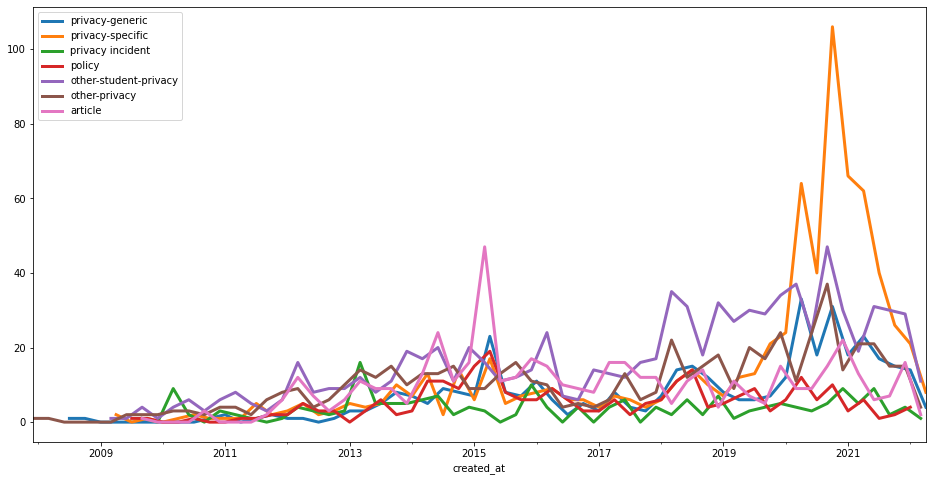

In [47]:
for code in ['privacy-generic', 'privacy-specific', 'privacy incident', 'policy', 'other-student-privacy', 'other-privacy', 'article']:
    labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M')).text.count().plot(label=code, linewidth=3, figsize=(16,8))
plt.legend()

### Who tweeted them?

In [9]:
'''Were a few people overly representitive?'''
print('unique authors: ', len(labled_df.author_id.unique()))
labled_df.groupby(['author_id']).text.count().sort_values(ascending=False).head(10)

unique authors:  3577


author_id
36991951      76
118530377     59
19895837      45
224059040     37
2968343710    33
216928966     24
2299828074    23
90749008      22
15694680      17
182539117     17
Name: text, dtype: int64

In [10]:
labled_df[labled_df.author_group!='unknown'].groupby(['code', 'author_group']).text.count().sort_values(ascending=False).head(20)

code                   author_group  
privacy-specific       academic_techi    125
article                academic_techi     99
privacy-generic        academic_techi     86
other-privacy          academic_techi     83
other-student-privacy  academic_techi     81
privacy-specific       academic           80
other-privacy          business_brand     76
other-student-privacy  academic           67
article                business_brand     66
                       personal_brand     62
other-student-privacy  business_brand     52
                       news               46
privacy-specific       business_brand     44
other-privacy          academic           44
                       personal_brand     37
other                  academic_techi     35
policy                 business_brand     35
other                  academic           34
privacy-specific       personal_brand     34
policy                 academic_techi     34
Name: text, dtype: int64

In [11]:
'''who tweeted generic and specific privacy concerns'''
print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().head(20).to_latex())

\begin{tabular}{llr}
\toprule
                 &        &  text \\
code & author\_group &       \\
\midrule
privacy-generic & academic &    33 \\
                 & academic\_techi &    86 \\
                 & business\_brand &    29 \\
                 & news &     7 \\
                 & personal\_brand &    25 \\
                 & techie &     7 \\
privacy-specific & academic &    80 \\
                 & academic\_techi &   125 \\
                 & business\_brand &    44 \\
                 & news &    16 \\
                 & personal\_brand &    34 \\
                 & techie &    27 \\
\bottomrule
\end{tabular}



/var/folders/1p/0rwj4hf522b5v3bzw33bsdqw0000gn/T/ipykernel_14335/3234389593.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(labled_df[(labled_df.author_group!='unknown') &((labled_df.code=='privacy-generic') | (labled_df.code=='privacy-specific'))].groupby(['code', 'author_group']).text.count().head(20).to_latex())


In [67]:
labled_df[(labled_df.author_group=='business_brand') & ( (labled_df.code=='privacy-specific'))][['text', 'author_group', 'author_id']]

,text,author_group,author_id
tweetid,,,
154305665295323137,"Microsoft's student social network, privacy concerns http://t.co/Azgqiqvs",business_brand,22120173
514128525998039040,Ovum: Lack of trust and privacy concerns are key barriers to #BYOD http://t.co/eDjJrKFPLF by @christhedj\n\n#enterprisemobility,business_brand,777335690
458684007111491584,Controversial education tech company InBloom has shut down over student data privacy concerns. Backed with $10... http://t.co/Uiq7OZWgkU,business_brand,110747266
154328629747265537,"Microsoft's student social network, privacy concerns: The social network market is saturated. Now, it seems, Mic... http://t.co/g1Si0BL6",business_brand,67908982
695133191183667200,Google invading student privacy with chromebooks: EFF #googleapps #googlebusiness #businss https://t.co/MdQIehRQuP,business_brand,104143144
1358850940745506817,"Well, ""privacy-focused"" does not mean ACTUAL #privacy but fake privacy or #marketing stunt. Use E2EE. https://t.co/B9A7LvVuSp",business_brand,26603208
1309284187749249024,@StateBarCA and @CaSupremeCourt what are you doing to protect Californian's privacy rights? \n\nTHIS IS EGREGIOUS. And super uncomfortable to know we can be surveilled by anyone who works at @ExamSoft who has access to hours of video footage of us. https://t.co/9kALup0W4V,business_brand,1296857348191870977
1057056769380364288,Our reliance on Facebook is a danger to our privacy - The Student https://t.co/MOFCmgESn3,business_brand,546910610
554985602999779329,#protectmyid #onlinesafety New Badges to Identify EdTech… http://t.co/WZlcotUHsf #PressReleases #parentingtips #privacy #myidentity,business_brand,2710492676


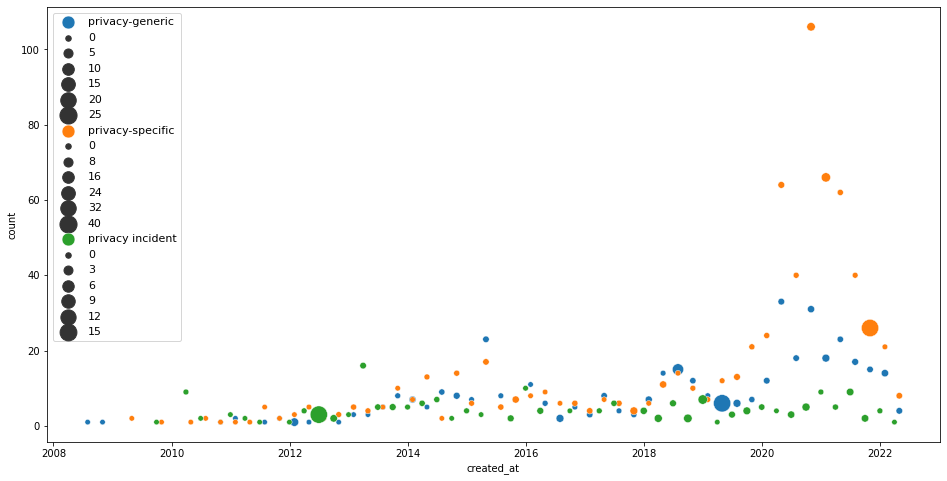

In [40]:
'''Retweets and likes on tweets expressing generic and specific concerns'''
plt.figure(figsize=(16, 8))
markers={'privacy-generic':'D', 'privacy-specific': 'o', 'privacy incident':'*'}
g=labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='6M'))
for code in ['privacy-generic', 'privacy-specific', 'privacy incident']:
    g = labled_df[labled_df.code==code].reset_index().set_index('created_at').groupby(pd.Grouper(freq='3M'))#.text.count().plot(label=code, marker="o", markersize=15, linestyle='none')

    gdf = g.text.agg(['count'])
    gdf['retweets'] = g.retweets.mean()
    gdf['likes'] = g.likes.mean()
    gdf.reset_index(inplace=True)
    sns.scatterplot(
        data=gdf, x='created_at', y='count',  size="retweets", label=code, marker='o',#markers[code],
        sizes=(30, 300), hue_norm=(0, 7)#, legend="full"
    )

plt.legend(title="", title_fontsize=12, fontsize=11, fancybox=True)
plt.show()

In [108]:
labled_df.groupby('code').retweets.mean().sort_values(ascending=False)

code
edtech ban               232.750000
privacy-specific           3.914483
privacy-generic            1.820197
other-student-privacy      1.500000
other-privacy              1.465157
article                    1.338057
info_brand                 1.244275
other                      0.981132
privacy incident           0.978947
policy                     0.977099
tech_brandi                0.860465
edtech-generic             0.578947
edtech-ques                0.400000
Name: retweets, dtype: float64

In [102]:
labled_df[labled_df.code=='edtech ban'][['text', 'retweets', 'likes']]

,text,retweets,likes
tweetid,,,
1363966363602051074,"So I've been stuck on the camera policy for my Zoom classes. I totally get the worries about student privacy and invasiveness. But I also know that my teaching gets radically worse when I'm facing mostly all black squares. So this time, I tried complete honesty.\n\nReport-thread:",930,4782
1207861674264412160,@33heupel Depending on what you can use in regards to Ss data privacy @Flipgrid could be a great tool here. #ditchbook,0,4
1249694208471863297,"@Garreth_Wigg @GoogleForEdu @MicrosoftEDU @AppleEDU yes they do have the same problem, a lot of these systems and services are restricted in our public schools. In the private sector however it is not so restrictive. new data privacy laws have had wide sweeping implications on how we obtain perm...",0,0
1357788885015789570,"So sad (and a bit surprised) that we are not able to suggest that our teachers use @Flipgrid anymore, since they won't sign our state student data privacy agreement. We love Flipgrid!💚",1,4


In [103]:
labled_df.groupby('code').likes.mean().sort_values(ascending=False)

code
edtech ban               1197.500000
privacy-specific            9.673103
privacy-generic             5.529557
other-student-privacy       5.171296
other                       4.577830
other-privacy               3.869338
edtech-generic              2.157895
policy                      1.801527
privacy incident            1.710526
info_brand                  1.618321
article                     1.566802
tech_brandi                 1.244186
edtech-ques                 1.222222
Name: likes, dtype: float64

### Keywords in each group

In [43]:
corpus=list(labled_df[(labled_df.code=='privacy-generic')].text_clean_topic.values)
top_words = (get_tfidf_top_features(corpus, n_top=25))
np.array(top_words)

array(['username', 'privacy', 'student', 'edtech', 'datum',
       'surveillance', 'school', 'issue', 'eddata', 'teacher', 'concern',
       'app', 'kid', 'security', 'parent', 'education', 'bad', 'protect',
       'child', 'online', 'tool', 'company', 'time', 'learn',
       'information'], dtype='<U17')

In [44]:
corpus=list(labled_df[(labled_df.code=='privacy-specific')].text_clean_topic.values)
top_words = (get_tfidf_top_features(corpus, n_top=25))
np.array(top_words)

array(['username', 'privacy', 'student', 'school', 'surveillance',
       'edtech', 'security', 'datum', 'issue', 'software', 'invasion',
       'app', 'violation', 'google', 'concern', 'exam', 'policy', 'kid',
       'zoom', 'teacher', 'bad', 'online', 'violate', 'proctorio', 'feel'],
      dtype='<U20')

In [194]:
corpus=list(labled_df[(labled_df.code=='article')].text_clean_topic.values)
top_words = (get_tfidf_top_features(corpus, n_top=20))
np.array(top_words)

array(['privacy', 'username', 'student', 'edtech', 'datum', 'school',
       'education', 'surveillance', 'eddata', 'issue', 'security',
       'edchat', 'concern', 'policy', 'protect', 'app', 'tech', 'law',
       'google', 'studentprivacy'], dtype='<U20')

### Entities in each group

In [187]:
'''what edtech providers were mentioned most in privacy groups'''
def common_mentions(kw):
    mentions = labled_df[labled_df.code==kw].mentions
    mentions = list(itertools.chain.from_iterable(mentions))
    mentions = [m.lower() for m in mentions]
    print("unique mentions:", len(set(mentions)))
    mentions = Counter(mentions)
    print(mentions.most_common(10))
common_mentions('privacy-specific')
common_mentions('privacy-generic')

unique mentions: 129
[('goguardian', 8), ('chegg', 7), ('examsoft', 6), ('edpuzzle', 5), ('pearsonvue', 4), ('linkletter', 3), ('googleforedu', 3), ('coursehero', 3), ('chegghelp', 3), ('classdojo', 2)]
unique mentions: 32
[('zdnet', 1), ('danielharvey9', 1), ('kmp39', 1), ('jeremycyoung', 1), ('edmodo', 1), ('mikemcsharry', 1), ('eileenbelastock', 1), ('edtechdigest', 1), ('douglevin', 1), ('managedmethods', 1)]


In [175]:
'''what urls/domains are used for article group'''
urls = labled_df[labled_df.code=='article'].urls
urls

tweetid
1339974630698856448    []
199919127895351296     []
540992121952423936     []
672312661560848384     []
561143099498721280     []
                       ..
183562595104600066     []
200969939442610177     []
342299881228099584     []
605423600452124674     []
512007017008218112     []
Name: urls, Length: 494, dtype: object

In [195]:
labled_df.senti

tweetid
1301656105626476546    negative
1312039409689255936    negative
570992748725194752     negative
1006594055432802305    negative
1352870101775654913    negative
                         ...   
245581393768366080     positive
245338142209605632      neutral
245238058423828480      neutral
245212511979319296      neutral
1024331454820446209     neutral
Name: senti, Length: 4648, dtype: object

In [49]:
x='@Schoology, @Schoolytics, @GoogleForEdu, @moodle, @MyPowerSchool, @CanvasLMS, @Educ_Technology, @EdTech_K12, @MerlynMind, @edXOnline, @DigitalPromise, @LearningAtScale, @edtechdigest, @edmodo, @ClassDojo, @Newsela, @quizizz, @blackboard, @edpuzzle, @PearDeck, @Flipgrid, @BookCreatorApp, @mergeedu, @BookCreatorApp, @Seesaw, @TeachFX, @udacity, @coursera, @udemy, @edXOnline, @MicrosoftEDU, @proctorio, @examity, @ProctortrackPro, @speedexam, @in_examonline, @MercerMettl, @Examus1, @ProctorU, @Verificient, @AIProctor, @ExamSoft, @conductexam, @ProctorExam, @PSIServicesLLC, @pearsonvue, @merittracsvc, @Civitaslearning, @DreamBox_Learn, @GoGuardian, @GuildEducation, @Instructure, @Chegg, @CreativeLive, @CourseHero, @Masterclass'
len(x.split(','))

56